In [1]:
import numpy as np
import pandas as pd
import keras.backend as K

from keras.models import Model, Sequential
from keras import models, layers, optimizers, regularizers
from keras.layers import Dense, Dropout, Input
from keras.optimizers import SGD
from keras.initializers import RandomNormal
from keras.utils.np_utils import to_categorical
from keras.engine.topology import Layer, InputSpec
from keras.callbacks import LearningRateScheduler


from sklearn.utils import shuffle
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.metrics import confusion_matrix
import keras
import matplotlib.pyplot as plt
from keras import layers
from keras import backend as K

/home/dougwoodward/CADS/thesis/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
kepler_data = pd.read_csv("kepler_data_full.csv", header=159)

In [3]:
k_data = kepler_data.copy()
k_data = k_data.drop(['rowid','kepid','tce_rogue_flag', 'tce_delivname', 'rowupdate', 
                           'tce_datalink_dvs', 'tce_datalink_dvr', 'tce_steff_prov', 
                           'tce_slogg_prov', 'tce_smet_prov','tce_sradius_prov', 'tce_limbdark_mod',
                           'tce_trans_mod', 'tce_eccen', 'tce_eccen_err', 'tce_longp', 'tce_longp_err'
                          ],axis=1)
# drop some columns that we will not be using
# starting with all NA columns
k_data.dropna(axis=1,how='any', inplace=True)

# drop all autovetter columns execpt the training set - as those are manually set - take as "truth"

k_data = k_data.drop(['av_vf_pc', 'av_vf_pc_err', 'av_vf_afp','av_vf_afp_err',
                           'av_vf_ntp', 'av_vf_ntp_err', 'av_pp_pc','av_pp_afp', 
                           'av_pp_ntp', 'tce_plnt_num'],axis=1)

# update to be categorical
#k_data = pd.get_dummies(k_data, columns=['av_training_set','av_pred_class'])

# train/test split
test = k_data.loc[k_data['av_training_set'] == "UNK"] # test data is all data labeled as UNK in av_training

y_test = test[['av_pred_class']]
y_test = pd.get_dummies(y_test)
x_test = test.drop(['av_training_set', 'av_pred_class'], axis=1)

train = k_data[k_data.av_training_set != "UNK"] # training data is all data that is AFP/NTP/PC

# the training labels are truth
y_train = train[['av_training_set']]
y_train = pd.get_dummies(y_train)
# we cluster without labels, then we augment data w/ cluster
x_train = train.drop(['av_training_set','av_pred_class'], axis=1)
#x_train = pd.get_dummies(x_train, columns=['av_training_set'])

x_test = test.av_pred_class
x_test = test.drop(['av_training_set','av_pred_class'], axis=1)



train_val_split_size = 1000

x_val = x_train[:train_val_split_size]
y_val = y_train[:train_val_split_size]
x_train = x_train[train_val_split_size:]
y_train = y_train[train_val_split_size:]

x_val = (x_val - x_train.mean()) / (x_train.max() - x_train.min())
x_train = (x_train - x_train.mean()) / (x_train.max() - x_train.min())

In [4]:
# ok - so we have a basic autoencoder
# but we did not do layerwise greedy pre training
# so we need to do that layerwise greedy pretrain
layer_sizes = [x_train.shape[1],500,500,2000,10]

# creates the layers to greedy layerwise pretrain
# takes par
def create_layers(layer_sizes):
    autoencoders = []
    encoders = []
    decoders = []
    for i in range(1, len(layer_sizes)):
        if i == len(layer_sizes) - 1:
            act = 'linear'
        else:
            act = 'relu'
        h = Dense(layer_sizes[i], activation=act,
                  input_shape=(layer_sizes[i-1],),
                  name='encoder_%d'%i,
                  bias_initializer='zeros',
                  kernel_initializer=RandomNormal(mean=0.0, stddev=0.01, seed=None))
        encoders.append(h)
        
        rev_i = len(layer_sizes) - i
        if i == 1:
            act = 'linear'
        else:
            act = 'relu'
        d = Dense(layer_sizes[i-1], activation=act,
                 name='decoder_%d'%rev_i,
                 bias_initializer='zeros',
                 kernel_initializer=RandomNormal(mean=0.0, stddev=0.01, seed=None))
        decoders.append(d)
        autoencoder = Sequential([
            Dropout(0.2, input_shape=(layer_sizes[i-1],),name='encoder_dropout_%d'%i),
            h,
            Dropout(0.2, name='decoder_dropout_%d'%rev_i),
            d
        ])
        autoencoder.compile(loss='mse', optimizer=SGD(lr=0.01, decay=0, momentum=0.9))
        autoencoders.append(autoencoder)
    return autoencoders, encoders, decoders

# build up some models
autoencoders, encoders, decoders = create_layers(layer_sizes)

encoder = Sequential(encoders)
encoder.compile(loss='mse', optimizer=SGD(lr=0.1, decay=0, momentum=0.9))
decoders.reverse()
autoencoder = Sequential(encoders + decoders)
autoencoder.compile(loss='mse', optimizer=SGD(lr=0.1, decay=0, momentum=0.9))


In [5]:
current_input = x_train.copy()
histories =[]

def step_decay(epoch):
    initial_lrate = 0.1
    drop_factor = int(epoch / 20000)
    lrate = initial_lrate / (10**drop_factor)
    return lrate

lr_schedule = LearningRateScheduler(step_decay)

# Greedy Layer Wise Training
for i, ae in enumerate(autoencoders):
    if i > 0:
        weights = encoders[i-1].get_weights()
        dense_layer = Dense(layer_sizes[i], input_shape=(current_input.shape[1],),
                            activation='relu', weights=weights,
                            name='encoder_dense_copy_%d'%i)
        encoder_model = Sequential([dense_layer])
        encoder_model.compile(loss='mse', optimizer=SGD(lr=0.01, decay=0, momentum=0.9))
        current_input = encoder_model.predict(current_input)
    histories.append(ae.fit(current_input, current_input,
                    batch_size=256, epochs=500, callbacks=[lr_schedule]))
    
    autoencoder.layers[i].set_weights(ae.layers[1].get_weights())
    autoencoder.layers[len(autoencoder.layers)-i-1].set_weights(ae.layers[-1].get_weights())
    

Epoch 1/500
14737/14737 [==============================] - 2s 106us/step - loss: 0.0123
Epoch 2/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0120
Epoch 3/500
14737/14737 [==============================] - 0s 8us/step - loss: 0.0116
Epoch 4/500
14737/14737 [==============================] - 0s 10us/step - loss: 0.0110
Epoch 5/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0101
Epoch 6/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0089
Epoch 7/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0076
Epoch 8/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0067
Epoch 9/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0060
Epoch 10/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0055
Epoch 11/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0052
Epoch 12/500
14737/14737 [=======================

14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 96/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 97/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 98/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 99/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 100/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 101/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 102/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 103/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 104/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 105/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 106/500
14737/14737 [=======================

14737/14737 [==============================] - 0s 9us/step - loss: 0.0018
Epoch 189/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0018
Epoch 190/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0018
Epoch 191/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0018
Epoch 192/500
14737/14737 [==============================] - 0s 8us/step - loss: 0.0018
Epoch 193/500
14737/14737 [==============================] - 0s 8us/step - loss: 0.0018
Epoch 194/500
14737/14737 [==============================] - 0s 10us/step - loss: 0.0017
Epoch 195/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0018
Epoch 196/500
14737/14737 [==============================] - 0s 8us/step - loss: 0.0018
Epoch 197/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0017
Epoch 198/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0018
Epoch 199/500
14737/14737 [==================

14737/14737 [==============================] - 0s 9us/step - loss: 0.0016
Epoch 282/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0016
Epoch 283/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0016
Epoch 284/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0016
Epoch 285/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0016
Epoch 286/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0016
Epoch 287/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0016
Epoch 288/500
14737/14737 [==============================] - 0s 8us/step - loss: 0.0016
Epoch 289/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0016
Epoch 290/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0016
Epoch 291/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0016
Epoch 292/500
14737/14737 [===================

14737/14737 [==============================] - 0s 9us/step - loss: 0.0016
Epoch 375/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 376/500
14737/14737 [==============================] - 0s 8us/step - loss: 0.0016
Epoch 377/500
14737/14737 [==============================] - 0s 8us/step - loss: 0.0016
Epoch 378/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0016
Epoch 379/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 380/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 381/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 382/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 383/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 384/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 385/500
14737/14737 [===================

14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 468/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 469/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 470/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 471/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 472/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 473/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 474/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 475/500
14737/14737 [==============================] - 0s 8us/step - loss: 0.0015
Epoch 476/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 477/500
14737/14737 [==============================] - 0s 9us/step - loss: 0.0015
Epoch 478/500
14737/14737 [===================

14737/14737 [==============================] - 0s 10us/step - loss: 8.1471e-04
Epoch 60/500
14737/14737 [==============================] - 0s 10us/step - loss: 8.0299e-04
Epoch 61/500
14737/14737 [==============================] - 0s 11us/step - loss: 7.9003e-04
Epoch 62/500
14737/14737 [==============================] - 0s 10us/step - loss: 7.7874e-04
Epoch 63/500
14737/14737 [==============================] - 0s 11us/step - loss: 7.6637e-04
Epoch 64/500
14737/14737 [==============================] - 0s 10us/step - loss: 7.5596e-04
Epoch 65/500
14737/14737 [==============================] - 0s 10us/step - loss: 7.4547e-04
Epoch 66/500
14737/14737 [==============================] - 0s 10us/step - loss: 7.3539e-04
Epoch 67/500
14737/14737 [==============================] - 0s 10us/step - loss: 7.2551e-04
Epoch 68/500
14737/14737 [==============================] - 0s 10us/step - loss: 7.1697e-04
Epoch 69/500
14737/14737 [==============================] - 0s 10us/step - loss: 7.0810e-04
E

14737/14737 [==============================] - 0s 10us/step - loss: 4.0355e-04
Epoch 148/500
14737/14737 [==============================] - 0s 10us/step - loss: 4.0101e-04
Epoch 149/500
14737/14737 [==============================] - 0s 10us/step - loss: 3.9811e-04
Epoch 150/500
14737/14737 [==============================] - 0s 10us/step - loss: 3.9518e-04
Epoch 151/500
14737/14737 [==============================] - 0s 10us/step - loss: 3.9272e-04
Epoch 152/500
14737/14737 [==============================] - 0s 11us/step - loss: 3.9009e-04
Epoch 153/500
14737/14737 [==============================] - 0s 10us/step - loss: 3.8759e-04
Epoch 154/500
14737/14737 [==============================] - 0s 10us/step - loss: 3.8495e-04
Epoch 155/500
14737/14737 [==============================] - 0s 10us/step - loss: 3.8253e-04
Epoch 156/500
14737/14737 [==============================] - 0s 10us/step - loss: 3.8002e-04
Epoch 157/500
14737/14737 [==============================] - 0s 10us/step - loss: 3.

14737/14737 [==============================] - 0s 10us/step - loss: 2.4690e-04
Epoch 236/500
14737/14737 [==============================] - 0s 10us/step - loss: 2.4590e-04
Epoch 237/500
14737/14737 [==============================] - 0s 10us/step - loss: 2.4486e-04
Epoch 238/500
14737/14737 [==============================] - 0s 10us/step - loss: 2.4462e-04
Epoch 239/500
14737/14737 [==============================] - 0s 11us/step - loss: 2.4348e-04
Epoch 240/500
14737/14737 [==============================] - 0s 10us/step - loss: 2.4258e-04
Epoch 241/500
14737/14737 [==============================] - 0s 10us/step - loss: 2.4186e-04
Epoch 242/500
14737/14737 [==============================] - 0s 10us/step - loss: 2.4049e-04
Epoch 243/500
14737/14737 [==============================] - 0s 10us/step - loss: 2.4044e-04
Epoch 244/500
14737/14737 [==============================] - 0s 10us/step - loss: 2.3903e-04
Epoch 245/500
14737/14737 [==============================] - 0s 10us/step - loss: 2.

14737/14737 [==============================] - 0s 10us/step - loss: 1.9467e-04
Epoch 324/500
14737/14737 [==============================] - 0s 11us/step - loss: 1.9325e-04
Epoch 325/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.9388e-04
Epoch 326/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.9302e-04
Epoch 327/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.9281e-04
Epoch 328/500
14737/14737 [==============================] - 0s 11us/step - loss: 1.9279e-04
Epoch 329/500
14737/14737 [==============================] - 0s 11us/step - loss: 1.9149e-04
Epoch 330/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.9189e-04
Epoch 331/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.9132e-04
Epoch 332/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.9102e-04
Epoch 333/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.

14737/14737 [==============================] - 0s 10us/step - loss: 1.6913e-04
Epoch 412/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.6845e-04
Epoch 413/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.6831e-04
Epoch 414/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.6868e-04
Epoch 415/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.6795e-04
Epoch 416/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.6778e-04
Epoch 417/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.6741e-04
Epoch 418/500
14737/14737 [==============================] - 0s 11us/step - loss: 1.6743e-04
Epoch 419/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.6661e-04
Epoch 420/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.6680e-04
Epoch 421/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.

14737/14737 [==============================] - 0s 10us/step - loss: 1.5182e-04
Epoch 500/500
14737/14737 [==============================] - 0s 10us/step - loss: 1.5160e-04
Epoch 1/500
14737/14737 [==============================] - 0s 24us/step - loss: 0.0021
Epoch 2/500
14737/14737 [==============================] - 0s 18us/step - loss: 0.0018
Epoch 3/500
14737/14737 [==============================] - 0s 18us/step - loss: 0.0015
Epoch 4/500
14737/14737 [==============================] - 0s 17us/step - loss: 0.0013
Epoch 5/500
14737/14737 [==============================] - 0s 18us/step - loss: 0.0012
Epoch 6/500
14737/14737 [==============================] - 0s 18us/step - loss: 0.0011
Epoch 7/500
14737/14737 [==============================] - 0s 18us/step - loss: 0.0011
Epoch 8/500
14737/14737 [==============================] - 0s 18us/step - loss: 0.0011
Epoch 9/500
14737/14737 [==============================] - 0s 18us/step - loss: 0.0010
Epoch 10/500
14737/14737 [===================

14737/14737 [==============================] - 0s 18us/step - loss: 2.6346e-04
Epoch 89/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.6068e-04
Epoch 90/500
14737/14737 [==============================] - 0s 17us/step - loss: 2.5714e-04
Epoch 91/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.5383e-04
Epoch 92/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.5109e-04
Epoch 93/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.4854e-04
Epoch 94/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.4490e-04
Epoch 95/500
14737/14737 [==============================] - 0s 17us/step - loss: 2.4283e-04
Epoch 96/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.3970e-04
Epoch 97/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.3674e-04
Epoch 98/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.3403e-04
E

14737/14737 [==============================] - 0s 18us/step - loss: 1.1401e-04
Epoch 177/500
14737/14737 [==============================] - 0s 17us/step - loss: 1.1308e-04
Epoch 178/500
14737/14737 [==============================] - 0s 17us/step - loss: 1.1257e-04
Epoch 179/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.1176e-04
Epoch 180/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.1110e-04
Epoch 181/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.1077e-04
Epoch 182/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.1019e-04
Epoch 183/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.0917e-04
Epoch 184/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.0875e-04
Epoch 185/500
14737/14737 [==============================] - 0s 17us/step - loss: 1.0817e-04
Epoch 186/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.

14737/14737 [==============================] - 0s 18us/step - loss: 8.0761e-05
Epoch 265/500
14737/14737 [==============================] - 0s 18us/step - loss: 8.0548e-05
Epoch 266/500
14737/14737 [==============================] - 0s 18us/step - loss: 8.0419e-05
Epoch 267/500
14737/14737 [==============================] - 0s 18us/step - loss: 7.9918e-05
Epoch 268/500
14737/14737 [==============================] - 0s 17us/step - loss: 8.0085e-05
Epoch 269/500
14737/14737 [==============================] - 0s 18us/step - loss: 7.9372e-05
Epoch 270/500
14737/14737 [==============================] - 0s 18us/step - loss: 7.9617e-05
Epoch 271/500
14737/14737 [==============================] - 0s 18us/step - loss: 7.9284e-05
Epoch 272/500
14737/14737 [==============================] - 0s 18us/step - loss: 7.9254e-05
Epoch 273/500
14737/14737 [==============================] - 0s 17us/step - loss: 7.8814e-05
Epoch 274/500
14737/14737 [==============================] - 0s 17us/step - loss: 7.

14737/14737 [==============================] - 0s 18us/step - loss: 6.4659e-05
Epoch 353/500
14737/14737 [==============================] - 0s 17us/step - loss: 6.4472e-05
Epoch 354/500
14737/14737 [==============================] - 0s 18us/step - loss: 6.4661e-05
Epoch 355/500
14737/14737 [==============================] - 0s 18us/step - loss: 6.4242e-05
Epoch 356/500
14737/14737 [==============================] - 0s 18us/step - loss: 6.4462e-05
Epoch 357/500
14737/14737 [==============================] - 0s 18us/step - loss: 6.4401e-05
Epoch 358/500
14737/14737 [==============================] - 0s 18us/step - loss: 6.4013e-05
Epoch 359/500
14737/14737 [==============================] - 0s 18us/step - loss: 6.4304e-05
Epoch 360/500
14737/14737 [==============================] - 0s 18us/step - loss: 6.3866e-05
Epoch 361/500
14737/14737 [==============================] - 0s 17us/step - loss: 6.4108e-05
Epoch 362/500
14737/14737 [==============================] - 0s 18us/step - loss: 6.

14737/14737 [==============================] - 0s 18us/step - loss: 5.8691e-05
Epoch 441/500
14737/14737 [==============================] - 0s 17us/step - loss: 5.8862e-05
Epoch 442/500
14737/14737 [==============================] - 0s 18us/step - loss: 5.8773e-05
Epoch 443/500
14737/14737 [==============================] - 0s 18us/step - loss: 5.8625e-05
Epoch 444/500
14737/14737 [==============================] - 0s 18us/step - loss: 5.8511e-05
Epoch 445/500
14737/14737 [==============================] - 0s 18us/step - loss: 5.8424e-05
Epoch 446/500
14737/14737 [==============================] - 0s 18us/step - loss: 5.8507e-05
Epoch 447/500
14737/14737 [==============================] - 0s 18us/step - loss: 5.8621e-05
Epoch 448/500
14737/14737 [==============================] - 0s 18us/step - loss: 5.8706e-05
Epoch 449/500
14737/14737 [==============================] - 0s 18us/step - loss: 5.8338e-05
Epoch 450/500
14737/14737 [==============================] - 0s 18us/step - loss: 5.

14737/14737 [==============================] - 0s 18us/step - loss: 2.3599e-04
Epoch 29/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.3497e-04
Epoch 30/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.3406e-04
Epoch 31/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.3326e-04
Epoch 32/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.3253e-04
Epoch 33/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.3189e-04
Epoch 34/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.3131e-04
Epoch 35/500
14737/14737 [==============================] - 0s 19us/step - loss: 2.3081e-04
Epoch 36/500
14737/14737 [==============================] - 0s 19us/step - loss: 2.3035e-04
Epoch 37/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2994e-04
Epoch 38/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2958e-04
E

14737/14737 [==============================] - 0s 18us/step - loss: 2.2613e-04
Epoch 118/500
14737/14737 [==============================] - 0s 19us/step - loss: 2.2610e-04
Epoch 119/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2610e-04
Epoch 120/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2609e-04
Epoch 121/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2608e-04
Epoch 122/500
14737/14737 [==============================] - 0s 19us/step - loss: 2.2606e-04
Epoch 123/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2606e-04
Epoch 124/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2604e-04
Epoch 125/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2602e-04
Epoch 126/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2601e-04
Epoch 127/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.

14737/14737 [==============================] - 0s 18us/step - loss: 2.2437e-04
Epoch 206/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2433e-04
Epoch 207/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2427e-04
Epoch 208/500
14737/14737 [==============================] - 0s 19us/step - loss: 2.2422e-04
Epoch 209/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2423e-04
Epoch 210/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2417e-04
Epoch 211/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2414e-04
Epoch 212/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2408e-04
Epoch 213/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2404e-04
Epoch 214/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.2402e-04
Epoch 215/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.

14737/14737 [==============================] - 0s 18us/step - loss: 2.1847e-04
Epoch 294/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.1835e-04
Epoch 295/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.1827e-04
Epoch 296/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.1808e-04
Epoch 297/500
14737/14737 [==============================] - 0s 19us/step - loss: 2.1799e-04
Epoch 298/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.1782e-04
Epoch 299/500
14737/14737 [==============================] - 0s 19us/step - loss: 2.1780e-04
Epoch 300/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.1775e-04
Epoch 301/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.1759e-04
Epoch 302/500
14737/14737 [==============================] - 0s 19us/step - loss: 2.1741e-04
Epoch 303/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.

14737/14737 [==============================] - 0s 18us/step - loss: 2.0150e-04
Epoch 382/500
14737/14737 [==============================] - 0s 19us/step - loss: 2.0137e-04
Epoch 383/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.0115e-04
Epoch 384/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.0086e-04
Epoch 385/500
14737/14737 [==============================] - 0s 19us/step - loss: 2.0077e-04
Epoch 386/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.0018e-04
Epoch 387/500
14737/14737 [==============================] - 0s 18us/step - loss: 2.0001e-04
Epoch 388/500
14737/14737 [==============================] - 0s 19us/step - loss: 1.9932e-04
Epoch 389/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.9926e-04
Epoch 390/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.9911e-04
Epoch 391/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.

14737/14737 [==============================] - 0s 18us/step - loss: 1.7037e-04
Epoch 470/500
14737/14737 [==============================] - 0s 19us/step - loss: 1.7019e-04
Epoch 471/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.6951e-04
Epoch 472/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.6919e-04
Epoch 473/500
14737/14737 [==============================] - 0s 19us/step - loss: 1.6846e-04
Epoch 474/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.6881e-04
Epoch 475/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.6788e-04
Epoch 476/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.6757e-04
Epoch 477/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.6717e-04
Epoch 478/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.6635e-04
Epoch 479/500
14737/14737 [==============================] - 0s 18us/step - loss: 1.

4


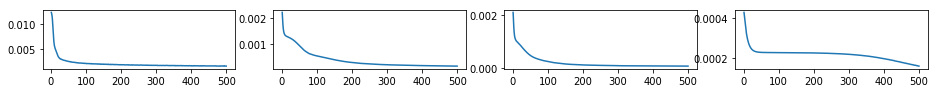

In [6]:
plt.clf()

tot = len(histories)
cols = 5
rows = tot//cols
rows += tot%cols

pos = range(1,tot+1)
print(tot)
fig = plt.figure(1, )
fig.set_figheight(5)
fig.set_figwidth(20)

for i,h in enumerate(histories):
    ax = fig.add_subplot(rows,cols,pos[i])
    loss = h.history['loss']
    epochs = range(1, len(loss)+1)
    ax.plot(epochs, loss)

plt.show()

In [7]:
history = autoencoder.fit(x_train, x_train, batch_size=256, epochs=300, validation_data=(x_val, x_val))

Train on 14737 samples, validate on 1000 samples
Epoch 1/300
14737/14737 [==============================] - 0s 32us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 2/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0058 - val_loss: 0.0056
Epoch 3/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0054 - val_loss: 0.0055
Epoch 4/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0053 - val_loss: 0.0054
Epoch 5/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0052 - val_loss: 0.0052
Epoch 6/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0051 - val_loss: 0.0051
Epoch 7/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0050 - val_loss: 0.0049
Epoch 8/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0048 - val_loss: 0.0047
Epoch 9/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0045 - val_loss: 0.00

14737/14737 [==============================] - 0s 23us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 78/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 79/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 80/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 81/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 82/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 83/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 84/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 85/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 86/300
14737/14737 [========================

14737/14737 [==============================] - 0s 22us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 154/300
14737/14737 [==============================] - 0s 22us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 155/300
14737/14737 [==============================] - 0s 22us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 156/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 157/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 158/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 159/300
14737/14737 [==============================] - 0s 22us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 160/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 161/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 162/300
14737/14737 [===============

Epoch 229/300
14737/14737 [==============================] - 0s 22us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 230/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 231/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 232/300
14737/14737 [==============================] - 0s 22us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 233/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 234/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 235/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 236/300
14737/14737 [==============================] - 0s 22us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 237/300
14737/14737 [==============================] - 0s 23us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 238/300
14737/14737 [=

In [8]:
autoencoder.save_weights('autoencoder.h5')

In [9]:
autoencoder.load_weights('autoencoder.h5')

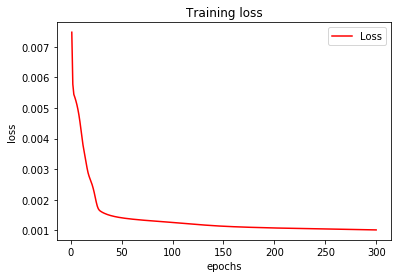

In [10]:
plt.clf()
loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'r', label='Loss')
plt.title('Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()

In [11]:
for i,layer in enumerate(encoder.layers):
    layer.set_weights(autoencoder.layers[i].get_weights())

In [12]:
class ClusteringLayer(Layer): 
    
    def __init__(self, output_dim, input_dim=None, weights=None, alpha=1.0, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.alpha = alpha        
        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]
        
        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(ClusteringLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]
        self.W = K.variable(self.initial_weights)
        self.trainable_weights = [self.W]
        
    def call(self, x, mask=None):
        q = 1.0/(1.0 + K.sqrt(K.sum(K.square(K.expand_dims(x, 1) - self.W), axis=2))**2/self.alpha)
        q = q**((self.alpha+1.0)/2.0)
        q = K.transpose(K.transpose(q)/K.sum(q, axis=1))
        return q
    
    def get_output_shape_for(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)
    
    def get_output_shape(self, input_shape):
        return self.get_output_shape(input_shape)
    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.output_dim
    
    def get_config(self):
        config = {'output_dim': self.output_dim,
                  'input_dim': self.input_dim}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items() + list(config.items)))
    

In [13]:
from sklearn.cluster import KMeans

cluster_centers = None
y_prediction = 0
n_clusters=3
# initialize cluster centres using k-means
print('Initializing cluster centres with k-means.')
if cluster_centers is None:
    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    y_prediction = kmeans.fit_predict(encoder.predict(x_train))
    cluster_centers = kmeans.cluster_centers_


Initializing cluster centres with k-means.


In [14]:
dec = Sequential([encoder,
                    ClusteringLayer(n_clusters,
                                    weights=cluster_centers,
                                    name='clustering')])

dec.compile(optimizer='adadelta',
              loss='kullback_leibler_divergence')

dec.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 10)                1318010   
_________________________________________________________________
clustering (ClusteringLayer) (None, 3)                 30        
Total params: 1,318,040
Trainable params: 1,318,040
Non-trainable params: 0
_________________________________________________________________


In [15]:
def p_mat(q):
    weight = q**2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

labels = {"av_training_set_AFP": 0,
          "av_training_set_NTP":1,
          "av_training_set_PC":2}

def cluster_acc(y_truth, y_pred):
    yidx = y_truth.idxmax(1).values
    y_true = np.vectorize(labels.get)(yidx)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max())+1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind])*1.0/y_pred.size, w

In [16]:
batch_size = 256
y = y_train
update_interval = 10
iteration = 0
index = 0
train_dec_epochs = 1000
master_acc = []
save_interval = x_train.shape[0]/batch_size*50
print(update_interval)
# training loop
for i in range(train_dec_epochs):

    if iteration % update_interval == 0:
        q = dec.predict(x_train, verbose=0)
        p = p_mat(q)
        y_pred = q.argmax(1)
        delta_label = ((y_pred != y_prediction).sum().astype(np.float32) / y_pred.shape[0])
        if y is not None:
            acc = cluster_acc(y, y_prediction)[0]
            master_acc.append(acc)
            print('Iteration '+str(i)+', Accuracy '+str(np.round(acc, 5)))
        else:
            print(str(np.round(delta_label*100, 5))+'%change in label assignment')
        print(str(np.round(delta_label*100, 5))+'%change in label assignment\n')            
        
        y_prediction = y_pred
        
    for i, layer in enumerate(encoder.layers):
        layer.set_weights(dec.layers[0].layers[i].get_weights())
    cluster_centers = dec.layers[-1].get_weights()[0]
    
    # cross validation
    if(index+1)*batch_size > x_train.shape[0]:
        loss = dec.train_on_batch(x_train[index*batch_size::], p[index*batch_size::],
                                    p[index*batch_size::])
        index = 0
    else:
        loss = dec.train_on_batch(x_train[index*batch_size:(index+1) * batch_size],
                                    p[index*batch_size:(index+1) * batch_size])
        index += 1
    iteration +=1

10
Iteration 0, Accuracy 0.56504
0.0%change in label assignment

Iteration 10, Accuracy 0.56504
2.65997%change in label assignment

Iteration 20, Accuracy 0.58499
3.41996%change in label assignment

Iteration 30, Accuracy 0.60949
4.18674%change in label assignment

Iteration 40, Accuracy 0.63378
2.82283%change in label assignment

Iteration 50, Accuracy 0.64572
2.41569%change in label assignment

Iteration 60, Accuracy 0.63704
7.89849%change in label assignment

Iteration 70, Accuracy 0.61586
16.85553%change in label assignment

Iteration 80, Accuracy 0.51259
9.09955%change in label assignment

Iteration 90, Accuracy 0.54875
13.24557%change in label assignment

Iteration 100, Accuracy 0.6101
12.58737%change in label assignment

Iteration 110, Accuracy 0.57549
5.75422%change in label assignment

Iteration 120, Accuracy 0.59517
6.52779%change in label assignment

Iteration 130, Accuracy 0.62489
8.45491%change in label assignment

Iteration 140, Accuracy 0.63982
1.47927%change in label as

In [17]:
# add the predicted class to the training set
dec_prediction = dec.predict(x_train, verbose=0)
dec_prediction_val = dec.predict(x_val, verbose=0)

In [19]:
# we will append all three cluster assignment probs[]
x_train['dec_pred_AFP'] = dec_prediction[:,0]
x_train['dec_pred_NTP'] = dec_prediction[:,1]
x_train['dec_pred_PC'] = dec_prediction[:,2]

x_val['dec_pred_AFP'] = dec_prediction_val[:,0]
x_val['dec_pred_NTP'] = dec_prediction_val[:,1]
x_val['dec_pred_PC'] = dec_prediction_val[:,2]

In [20]:
# use a basic feed forward neural net to classify
# be really dumb and just attempt to pass into a net
classifier = models.Sequential()
classifier.add(layers.Dense(1,kernel_initializer='glorot_uniform',
                       kernel_regularizer=regularizers.l2(0.01),
                       activation='relu', 
                       input_shape=(x_train.shape[1],)))
classifier.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
classifier.add(layers.Dense(3, activation='softmax'))


classifier.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

classifier.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 94        
_________________________________________________________________
dense_2 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 153       
Total params: 347
Trainable params: 347
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = classifier.fit(x_train,
                    y_train.values,
                    epochs=200,
                    batch_size=256,
                    validation_data=(x_val, y_val.values))

Train on 14737 samples, validate on 1000 samples
Epoch 1/200
14737/14737 [==============================] - 0s 22us/step - loss: 1.0642 - acc: 0.6061 - val_loss: 0.9860 - val_acc: 0.6640
Epoch 2/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.9737 - acc: 0.6061 - val_loss: 0.8982 - val_acc: 0.6640
Epoch 3/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.9283 - acc: 0.6061 - val_loss: 0.8595 - val_acc: 0.6640
Epoch 4/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.8775 - acc: 0.6064 - val_loss: 0.8007 - val_acc: 0.6660
Epoch 5/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.8100 - acc: 0.6676 - val_loss: 0.7424 - val_acc: 0.7270
Epoch 6/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.7568 - acc: 0.6987 - val_loss: 0.7076 - val_acc: 0.7360
Epoch 7/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.7297 - acc: 0.6984 - val_loss: 0.6898 - v

14737/14737 [==============================] - 0s 12us/step - loss: 0.5761 - acc: 0.7808 - val_loss: 0.5840 - val_acc: 0.7880
Epoch 60/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.5757 - acc: 0.7814 - val_loss: 0.5782 - val_acc: 0.7840
Epoch 61/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.5752 - acc: 0.7803 - val_loss: 0.5768 - val_acc: 0.7950
Epoch 62/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.5746 - acc: 0.7810 - val_loss: 0.5811 - val_acc: 0.7950
Epoch 63/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.5746 - acc: 0.7820 - val_loss: 0.5764 - val_acc: 0.7910
Epoch 64/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.5738 - acc: 0.7803 - val_loss: 0.5790 - val_acc: 0.7830
Epoch 65/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.5738 - acc: 0.7803 - val_loss: 0.5801 - val_acc: 0.7970
Epoch 66/200
14737/14737 [==============

Epoch 118/200
14737/14737 [==============================] - 0s 13us/step - loss: 0.5608 - acc: 0.7874 - val_loss: 0.5722 - val_acc: 0.7850
Epoch 119/200
14737/14737 [==============================] - 0s 12us/step - loss: 0.5612 - acc: 0.7865 - val_loss: 0.5629 - val_acc: 0.8040
Epoch 120/200
14737/14737 [==============================] - 0s 12us/step - loss: 0.5608 - acc: 0.7861 - val_loss: 0.5649 - val_acc: 0.8070
Epoch 121/200
14737/14737 [==============================] - 0s 12us/step - loss: 0.5607 - acc: 0.7871 - val_loss: 0.5632 - val_acc: 0.8020
Epoch 122/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.5606 - acc: 0.7868 - val_loss: 0.5664 - val_acc: 0.7900
Epoch 123/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.5604 - acc: 0.7887 - val_loss: 0.5616 - val_acc: 0.8040
Epoch 124/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.5605 - acc: 0.7873 - val_loss: 0.5607 - val_acc: 0.8020
Epoch 125/200
14737/

14737/14737 [==============================] - 0s 11us/step - loss: 0.5541 - acc: 0.7888 - val_loss: 0.5565 - val_acc: 0.8090
Epoch 177/200
14737/14737 [==============================] - 0s 12us/step - loss: 0.5540 - acc: 0.7890 - val_loss: 0.5555 - val_acc: 0.8030
Epoch 178/200
14737/14737 [==============================] - 0s 12us/step - loss: 0.5538 - acc: 0.7896 - val_loss: 0.5552 - val_acc: 0.7930
Epoch 179/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.5535 - acc: 0.7860 - val_loss: 0.5552 - val_acc: 0.8020
Epoch 180/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.5537 - acc: 0.7893 - val_loss: 0.5551 - val_acc: 0.8060
Epoch 181/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.5537 - acc: 0.7876 - val_loss: 0.5528 - val_acc: 0.8100
Epoch 182/200
14737/14737 [==============================] - 0s 11us/step - loss: 0.5532 - acc: 0.7884 - val_loss: 0.5567 - val_acc: 0.7900
Epoch 183/200
14737/14737 [=======

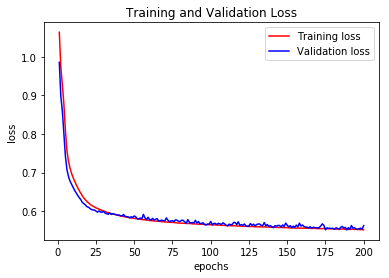

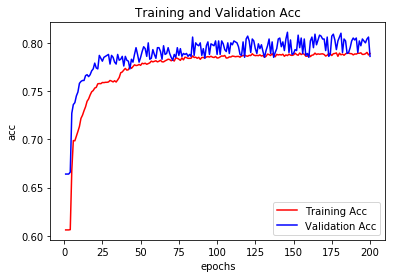

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) +1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()


plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'r', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Acc')
plt.xlabel('epochs')
plt.ylabel('acc')

plt.legend()
plt.show()

In [23]:
y_train_pred = classifier.predict(x_train)

confusion_matrix(y_train.values.argmax(1), y_train_pred.argmax(1), sample_weight=None)

array([[8484,  160,  288],
       [1886,  491,   23],
       [ 800,    1, 2604]])

In [24]:
dec_prediction_test = dec.predict(x_test, verbose=0)

x_test['dec_pred_AFP'] = dec_prediction_test[:,0]
x_test['dec_pred_NTP'] = dec_prediction_test[:,1]
x_test['dec_pred_PC'] = dec_prediction_test[:,2]

test_predictions = classifier.predict(x_test)

confusion_matrix(y_test.values.argmax(1), test_predictions.argmax(1), sample_weight=None)


array([[   0,    2,  724],
       [   0,    0, 3611],
       [   0,    0,  293]])

In [25]:
test_predictions
dec_prediction_test


array([[0.3333333, 0.3333333, 0.3333333],
       [0.3333333, 0.3333333, 0.3333333],
       [0.3333333, 0.3333333, 0.3333333],
       ...,
       [0.3333333, 0.3333333, 0.3333333],
       [0.3333333, 0.3333333, 0.3333333],
       [0.3333333, 0.3333333, 0.3333333]], dtype=float32)